In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import datasets, models, transforms

from tqdm import tqdm

import pylab as pl
import matplotlib.pyplot as plt
from IPython import display

# Transferència de coneixement

L'objectiu d'avui és aprendre com podem emprar arquitectures ja existents per resoldre els nostres problemes. 

Com objectius secundaris tenim:

1. Conèixer un nou conjunt de dades
2. Entendre en profunditat com són dos dels models més emprats.
3. Guardar i carregar xarxes neuronals

## Dades

El conjunt de dades [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) consta de 60.000 imatges en color de 32x32 pixels etiquetades en 10 classes, amb 6.000 imatges per classe. Hi ha 50.000 imatges d'entrenament i 10.000 imatges de _test_.

### Feina a fer:

1. Adaptar la mateixa xarxa que vareu desenvolupar la setmana anterior per emprar aquest conjunt de dades. `Grayscale` és una funció que transforma imatges a escala de grisos, la podem emprar dins la nostra composició de transformacions.

Si voleu normalitzar les dades, a continuació teniu els valors ja calculats:

  - mitjana: (0.4914, 0.4822, 0.4465)
  - desviació típica: (0.247, 0.243, 0.261)

Una altra funció que pot ser útil és `Resize(mida_desti)` que rep un enter com a paràmetre (la mida final).


In [4]:
train_batch_size = 64
test_batch_size = 100

# Definim una seqüència (composició) de transformacions 
transform=transforms.Compose([
    transforms.ToTensor(), #,
    transforms.Resize(227, antialias=True),
    ])

# Descarregam un dataset ja integrat en la llibreria Pytorch
train_data = datasets.CIFAR10('data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False, transform=transform)

# Transformam les dades en l'estructura necessaria per entrenar una xarxa
train_loader = torch.utils.data.DataLoader(train_data, train_batch_size)
test_loader = torch.utils.data.DataLoader(test_data, test_batch_size)

Files already downloaded and verified


In [33]:
classes = train_data.__dict__["classes"]

**Sempre està bé fer algunes comprovacions de com són les dades d'entrada**

In [35]:
iterador =  iter(train_loader) # Un iterador!!

In [36]:
features, labels = next(iterador)

# TODO: mostrar una imatge del batch i com a títol posar l'etiqueta.
# Extra: mostrar una graella amb tot el batch·

print("Saber l'estructura del batch us ajudarà: ")
print(f"Feature batch shape: {features.size()}")
print(f"Labels batch shape: {labels.size()}")


Saber l'estructura del batch us ajudarà: 
Feature batch shape: torch.Size([64, 3, 227, 227])
Labels batch shape: torch.Size([64])


## Transfer learning (Definició de la xarxa)

En aquesta pràctica aplicarem la tècnica de _transfer learning_ a partir de dues de les xarxes més conegudes en el camp de visió per computador:

-[**AlexNet**](https://proceedings.neurips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf). (ImageNet Classification with Deep Convolutional Neural Network, 2012). Amb prop de 60 milions de paràmetres entrenables.

[**MobileNet v3**](https://pytorch.org/vision/main/models/mobilenetv3.html): és una arquitectura de xarxa neuronal convolucional dissenyada per a aplicacions de visió per ordinador en dispositius mòbils i sistemes encastats. Va ser desenvolupada per Google a la seva sèrie MobileNet, que se centra en l'eficiència i el rendiment de les xarxes neuronals en dispositius amb recursos limitats, com ara telèfons mòbils. Té dues versions: _small_ amb configuracions que van dels 2 als 5 millons de paràmetres; _large_ amb uns 6 milions de paràmetres.

_Pytorch_ ens permet emprar aquestes xarxes de manera molt senzilla. [Més informació](https://pytorch.org/vision/stable/models.html).

Si el model que cercam no es troba integrat dins la llibreria _Pytorch_ és bastant probable que si la trobem a Huggingface.

Anem a descarregar AlexNet i a analitzar-la. En aquest cas no només ens baixam la seva arquitectura, també els pesos resultants de l'entrenament.

In [5]:
alex = models.alexnet(weights="AlexNet_Weights.IMAGENET1K_V1")

print("-"*50)
print("Arquitectura AlexNet")
print("-"*50)
print(alex)

--------------------------------------------------
Arquitectura AlexNet
--------------------------------------------------
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classi

Hi ha diverses maneres de realitzar la tècnica de _TransferLearning_ les dues més conegudes són:

 - **"Congelar"** els pesos de la part d'extracció de característiques (la part convolucional) i crear un nou classificador que s'adapti al nostre problema. Això implica que només entrenam una part de la xarxa.
 - **Reentrenar tota la xarxa**.

Com que la nostra capacitat de càlcul és limitada, ens decantarem per la primera opció. Pensau que

 Per tal d'evitar el reentrenament necessitam canviar el valor de l'atribut  `requires_grad` al valor `False`. Aquest atribut és propietat de cada tensor. Podem recorrer els tensors mitjançant el següent codi:
 ```
for param in alex.features.parameters():
    param.requires_grad = False
 ```

 ### Feina a fer:

 1. Carregar la xarxa AlexNet i seleccionar la part d'extracció de característiques.
 2. Definir un entorn seqüencial on implementarem el classificador de la xarxa.
 3. Realitzar un entrenament i comparar els resultats amb el primer entrenament (xarxa pròpia): comparar rendiment (accuracy) però també temps dedicat a entrenar i nombre de paràmetres.
 4. Provar de guardar la vostra xarxa i tornar-la a carregar. Per classificar una imatge del conjunt de test.

In [21]:
for param in alex.features.parameters():
    param.requires_grad = False

my_net =  nn.Sequential(alex.features,
                        nn.Flatten(1,-1),
                        nn.Dropout(p=0.5),
                        nn.Linear(in_features=9216, out_features=2048, bias=True),
                        nn.ReLU(),
                        nn.Dropout(p=0.5),
                        nn.Linear(in_features=2048, out_features=1024, bias=True),
                        nn.ReLU(),
                        nn.Dropout(p=0.5),
                        nn.Linear(in_features=1024, out_features=10, bias=True)
                        )

## Entrenament

[shhht](https://github.com/tqdm/tqdm) si voleu canviar el resum de l'entrenament per una barra de progrés

In [7]:
def train(model, device, train_loader, optimizer, epoch, log_interval=100, verbose=True):
    
    model.train()

    loss_v = 0

    for batch_idx, (data, target) in enumerate(train_loader):
    
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target, reduction='mean') 
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0 and verbose:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Average: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), loss.item()/ len(data)))
        loss_v += loss.item()

    loss_v /= len(train_loader.dataset)
    #print('\nTrain set: Average loss: {:.4f}\n'.format(loss_v))
 
    return loss_v


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='mean') 
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max probability
            correct += pred.eq(target.view_as(pred)).sum().item()
 
  
    test_loss /= len(test_loader.dataset)

    #print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    #    test_loss, correct, len(test_loader.dataset),
    #    100. * correct / len(test_loader.dataset)))
    
    return test_loss

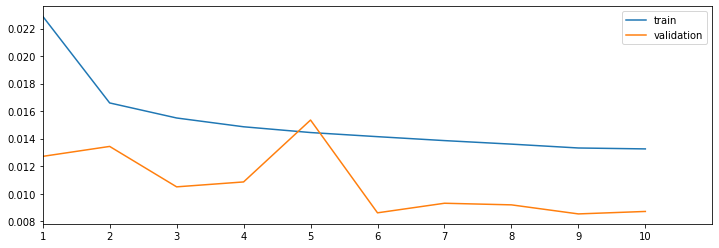

100%|██████████| 10/10 [14:08<00:00, 84.88s/it]


In [26]:
use_cuda = True
torch.manual_seed(33)

if use_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

epochs = 10
lr = 1e-1

model = my_net.to(device)

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # !!!

print("Parameters ", pytorch_total_params)
optimizer = optim.SGD(model.parameters(), lr=lr)

# Guardam el valor de pèrdua mig de cada iteració (època)
train_l = np.zeros((epochs))
test_l = np.zeros((epochs))

pbar = tqdm(range(1, epochs+1)) # tdqm permet tenir text dinàmic
for epoch in pbar:
    train_l[epoch-1] = train(model, device, train_loader, optimizer, epoch, verbose=False)
    test_l[epoch-1]  = test(model, device, test_loader)
    
    plt.figure(figsize=(12, 4))
    pl.plot(train_l[:epoch], label="train")
    pl.plot(test_l[:epoch], label="validation")
    pl.legend()
    pl.xlim(0, epochs)
    pl.xticks(range(0,epochs,1),range(1,epochs+1,1))
    
    display.clear_output(wait=True)
    display.display(pl.gcf())
    plt.close()


### Predicció de la xarxa Alexnet

In [27]:
from sklearn.metrics import accuracy_score

model.eval() # Posam la xarxa en mode avaluació

targets = []
predictions = []

with torch.no_grad(): # desactiva el càlcul de gradients, no ho necessitam per l'inferència. Estalvia memòria i fa més ràpids els càlculs
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)  # index amb la max probabilitat
        targets.extend(target.tolist())
        predictions.extend(torch.flatten(pred.cpu()).tolist())
        
targets = np.asarray(targets)
predictions = np.asarray(predictions)

print(f"Accuracy: {accuracy_score(targets, predictions)}")

Accuracy: 0.6925


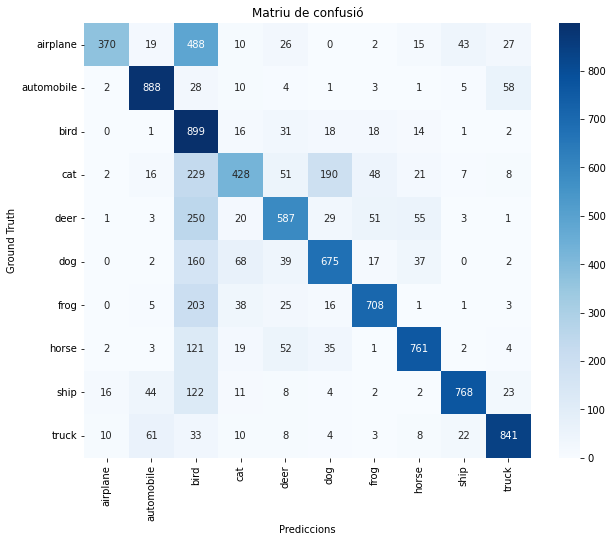

In [34]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(targets, predictions)

# Visualize confusion matrix with seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=classes, yticklabels=classes)
plt.xlabel('Prediccions')
plt.ylabel('Ground Truth')
plt.title('Matriu de confusió')
plt.show()